In [5]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import cv2
import keras
from keras.preprocessing import image
from PIL import Image
import PIL

import import_ipynb
import ExtractFeature
import Categorize

In [6]:
cnnmodel = keras.models.load_model('model/CNN_Model.model',compile=False)

print("Model Loaded")

Model Loaded


In [7]:
def on_button_clicked(b):
    

    WIDTH=850
    filename = 'upload.png'
    savename = 'uploadresize.png'
    uploaded_filename = next(iter(uploader.value))
    content = uploader.value[uploaded_filename]['content']
    with open(filename, 'wb') as f: 
        f.write(content)
    
    img2 = Image.open(filename)
    wpercent = (WIDTH / float(img2.size[0]))
    HEIGHT = int((float(img2.size[1]) * float(wpercent)))
    resized_img = img2.resize((WIDTH, HEIGHT), PIL.Image.ANTIALIAS)
    resized_img.save(savename)
    
    f, ax = plt.subplots(2,2,figsize = (50,50))
    #plt.figure(figsize=(16,10))
    image1 = cv2.imread(savename)
    ax[0,0].imshow(image1)
    ax[0,0].set_title('Uploaded Image',size=40)
    #plt.show()
    
    filtered = ExtractFeature.bilateralFilter(image1, 3)
    #plt.figure(figsize=(12,10))
    ax[0,1].imshow(filtered)
    ax[0,1].set_title('Bilateral Filter Applied Image',size=40)
    #plt.show()

    # convert to grayscale and binarize the image by INVERTED binary thresholding
    thresh = ExtractFeature.threshold(filtered, 120)
    #plt.figure(figsize=(12,10))
    ax[1,0].imshow(thresh)
    ax[1,0].set_title('Inverted Binary Thresholding Applied Image',size=40)
    #plt.show()

    # dilate the handwritten lines in image with a suitable kernel for contour operation
    dilated = ExtractFeature.dilate(thresh, (5 ,100))
    #plt.figure(figsize=(12,10))
    ax[1,1].imshow(dilated)
    ax[1,1].set_title('Dilated Image',size=40)
    plt.show()
    
    features = ExtractFeature.featureExtract(image1)
    
    baseline_value,baseline_type = Categorize.determine_baseline_angle(features[0])
    topm_value,topm_type = Categorize.determine_top_margin(features[1])
    lettersize_value,lettersize_type = Categorize.determine_letter_size(features[2])
    line_value,line_type = Categorize.determine_line_spacing(features[3])
    word_value,word_type = Categorize.determine_word_spacing(features[4])
    pen_value,pen_type = Categorize.determine_pen_pressure(features[5])
    slant_value,slant_type = Categorize.determine_slant_angle(features[6])
    
    x = PrettyTable()
    x.field_names = ["Features", "Value","Type"]


    x.add_row(["Baseline", features[0], baseline_type])
    x.add_row(["Top Margin", features[1], topm_type])
    x.add_row(["Letter Size", features[2],lettersize_type])
    x.add_row(["Line Spacing", features[3],line_type])
    x.add_row(["Word Spacing", features[4],word_type])
    x.add_row(["Pen Pressure", features[5], pen_type])
    x.add_row(["Slant", features[6], slant_type])
    
    print(x)
    
    x = PrettyTable()
    x.field_names = ["Personality Based on Features", "Prediction"]
    
    trait1 = Categorize.determine_trait_1(baseline_value, slant_value)
    if trait1 == 1:
        trait1="Stable"
    else:
        trait1="Not Stable"
    
    trait2 = Categorize.determine_trait_2(lettersize_value, pen_value)
    if trait2 == 1:
        trait2="High"
    else:
        trait2="Low"
    
    trait3 = Categorize.determine_trait_3(topm_value, lettersize_value)
    if trait3 == 1:
        trait3="Observed"
    else:
        trait3="Not Observed"
        
    trait4 = Categorize.determine_trait_4(line_value, word_value)
    if trait4 == 1:
        trait4="Harmonius"
    else:
        trait4="Not Harmonius"
        
    trait5 = Categorize.determine_trait_5(topm_value, slant_value)
    if trait5 == 1:
        trait5="Observed"
    else:
        trait5="Not Observed"
        
    trait6 = Categorize.determine_trait_6(lettersize_value, line_value)
    if trait6 == 1:
        trait6="Observed"
    else:
        trait6="Not Observed"
        
    trait7 = Categorize.determine_trait_7(lettersize_value, word_value)
    if trait7 == 1:
        trait7="Observed"
    else:
        trait7="Not Observed"
    
    trait8 = Categorize.determine_trait_8(line_value, word_value)
    if trait8 == 1:
        trait8 ="Observed"
    else:
        trait8 ="Not Observed"
    
    x.add_row(["Emotional Stability", trait1])
    x.add_row(["Will Power", trait2])
    x.add_row(["Modesty", trait3])
    x.add_row(["Personal Harmony & Flexibility", trait4])
    x.add_row(["Lack of Discipline", trait5])
    x.add_row(["Poor Concentration Power", trait6])
    x.add_row(["Non Communicativeness", trait7])
    x.add_row(["Social Isolation", trait8])
    
    print(x)
    
    img = image.load_img(savename,target_size=(400,400,3))
    img = image.img_to_array(img)
    img = img/255
    img_array = np.expand_dims(img, axis = 0)
    features = np.array([features])
    proba = cnnmodel.predict([img_array,features])
    #proba = cnnmodel.predict(img.reshape(1,400,400,3))
    
    x = PrettyTable()
    x.field_names = ["Personality Based on CNN Model", "Prediction"]


    x.add_row(["Pessimistic (Descending Baseline)", '{:.3f}'.format(proba[0][0])])
    x.add_row(["Optimistic (Ascending Baseline)", '{:.3f}'.format(proba[0][1])])
    x.add_row(["Balanced (Straight Baseline)", '{:.3f}'.format(proba[0][2])])
    x.add_row(["Good Taste & Independent (Wide Spacing)", '{:.3f}'.format(proba[0][3])])
    x.add_row(["Poor Taste & Independent (Narrow Spacing)", '{:.3f}'.format(proba[0][4])])
    x.add_row(["Social Maturity (Balanced Spacing)", '{:.3f}'.format(proba[0][5])])
    x.add_row(["Shy & Reserved (Left Slant)", '{:.3f}'.format(proba[0][6])])
    x.add_row(["Pragmatic & Impulsive (Right Slant)", '{:.3f}'.format(proba[0][7])])
    x.add_row(["Self Reliant (Straight Slant)", '{:.3f}'.format(proba[0][8])])
    x.add_row(["Moody & Unsettled (Irregular Slant)", '{:.3f}'.format(proba[0][9])])
    print(x)
    #print(proba)

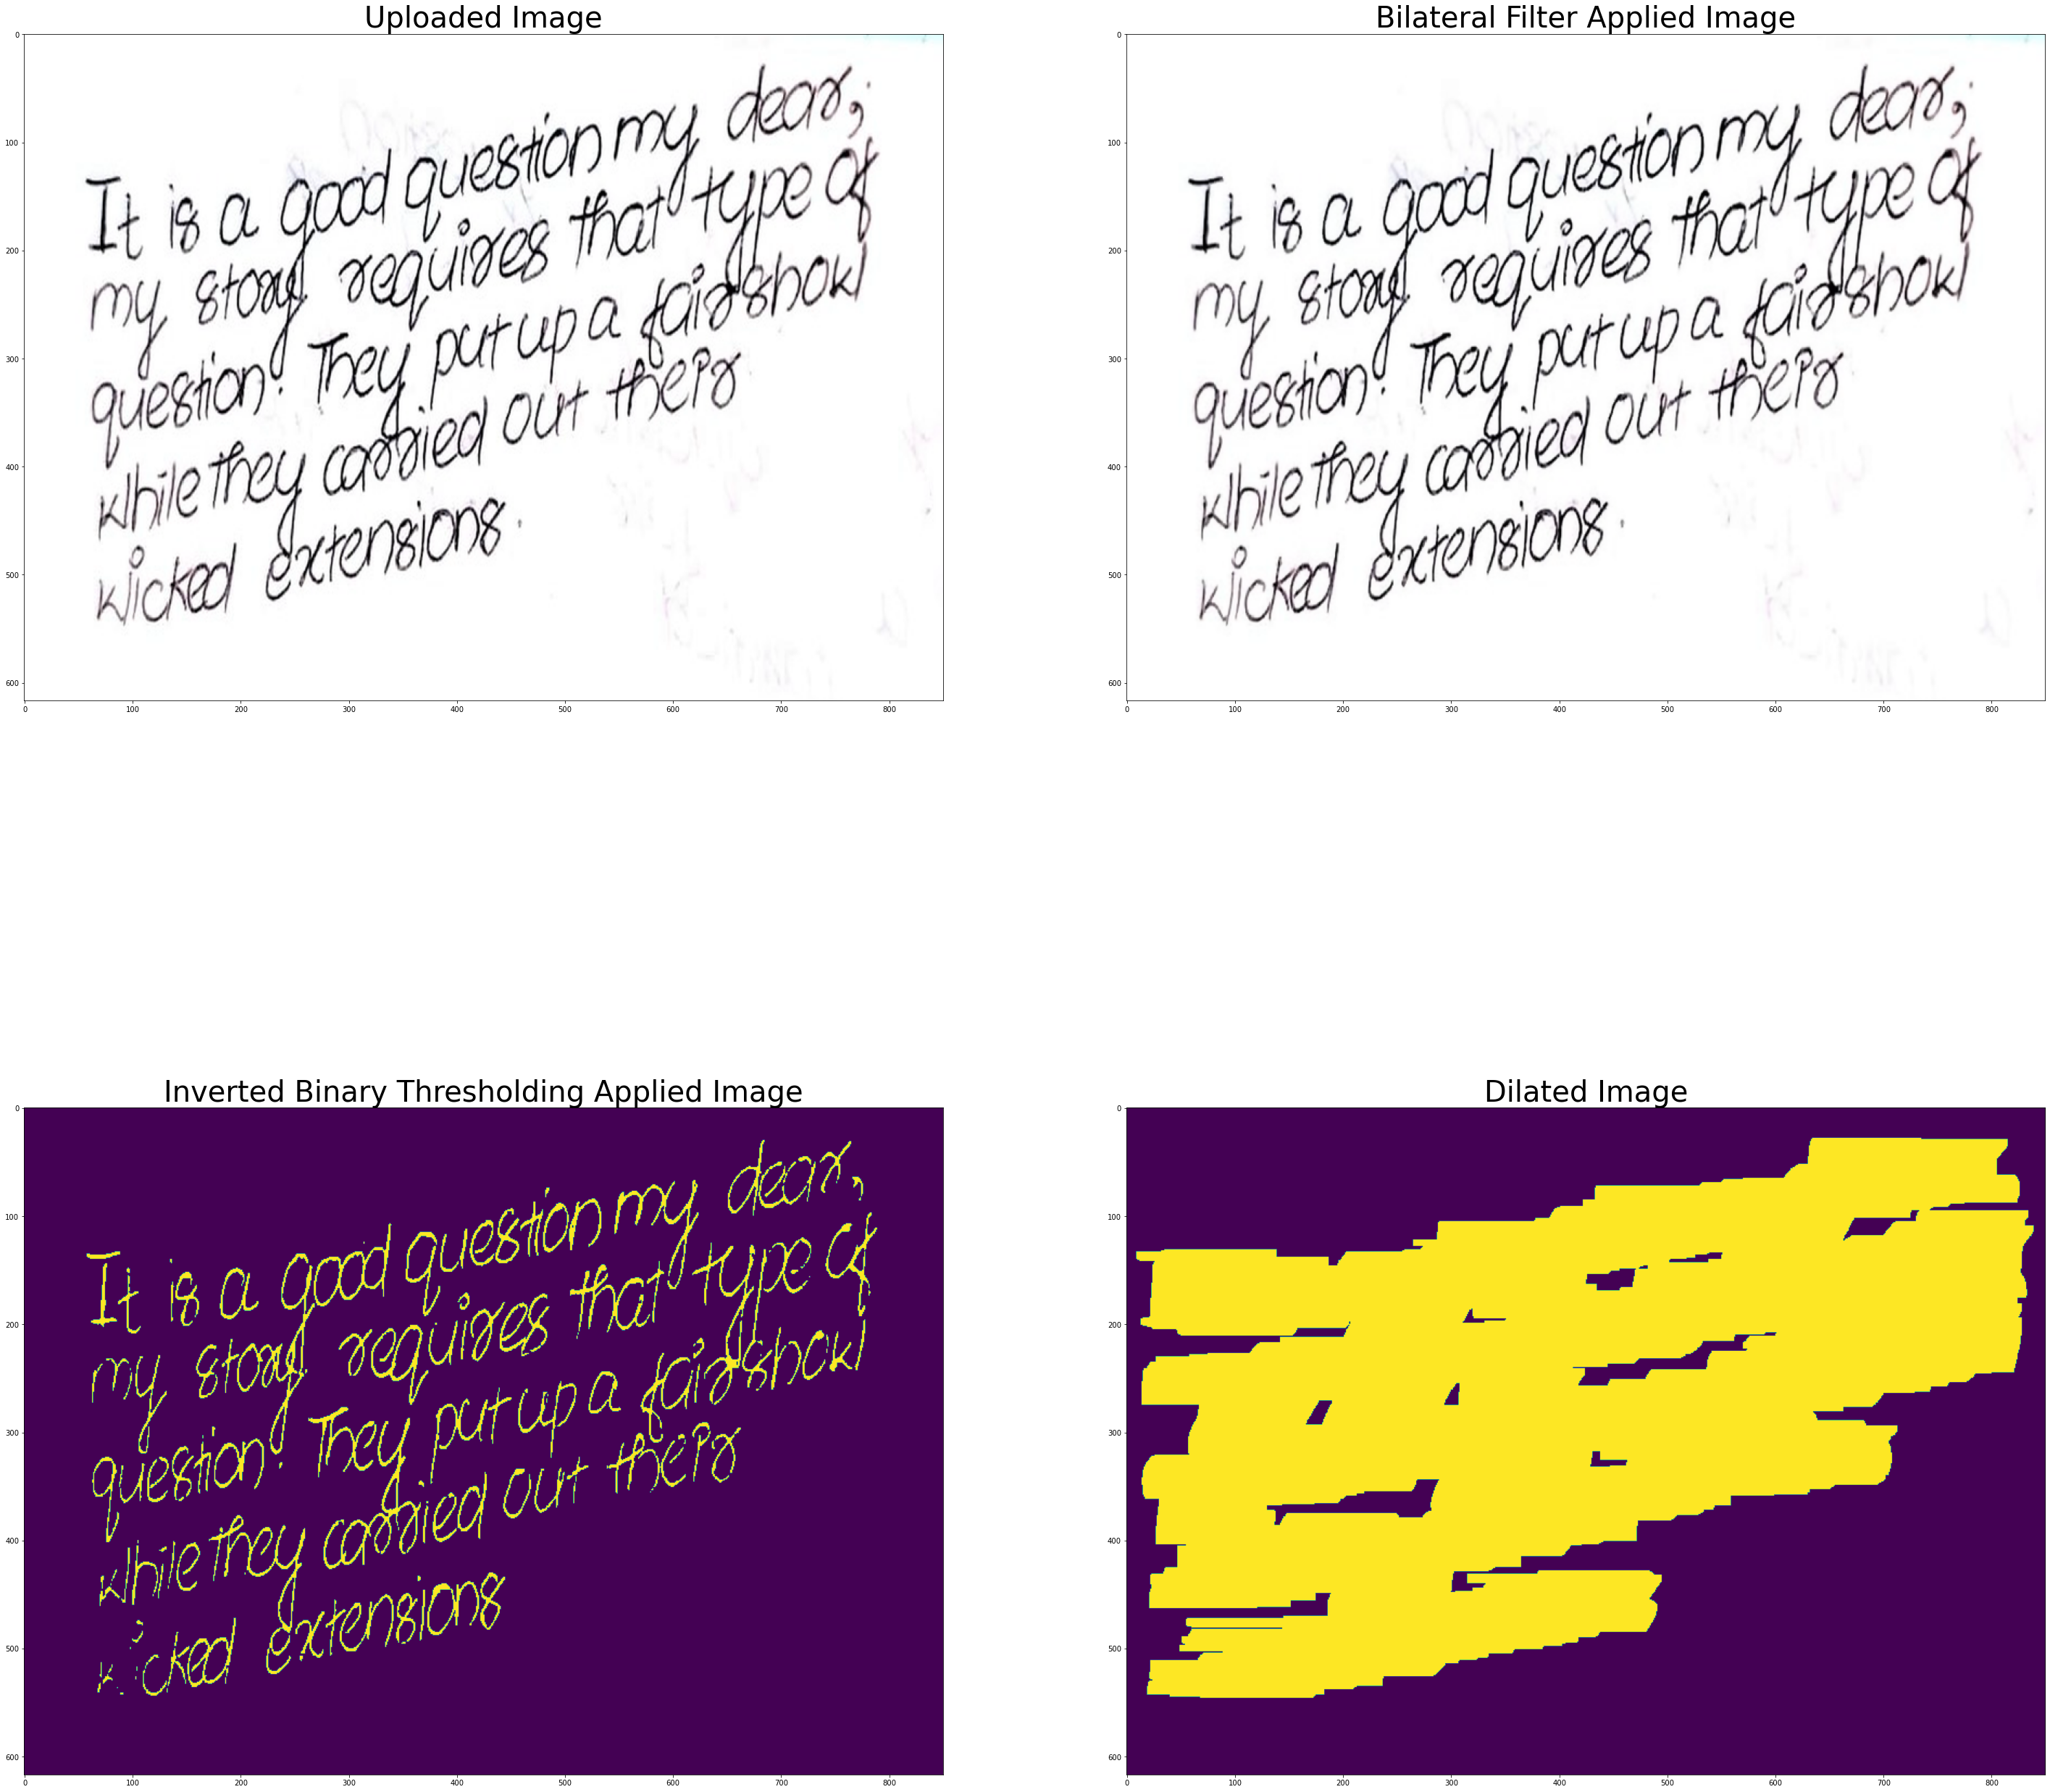

+--------------+-------+-------------------+
|   Features   | Value |        Type       |
+--------------+-------+-------------------+
|   Baseline   | -9.54 |     ASCENDING     |
|  Top Margin  |  1.07 |       NARROW      |
| Letter Size  |  71.0 |        BIG        |
| Line Spacing |  0.46 |       SMALL       |
| Word Spacing |  0.0  |       SMALL       |
| Pen Pressure | 182.4 |       HEAVY       |
|    Slant     |   15  | A LITTLE INCLINED |
+--------------+-------+-------------------+
+--------------------------------+---------------+
| Personality Based on Features  |   Prediction  |
+--------------------------------+---------------+
|      Emotional Stability       |     Stable    |
|           Will Power           |      High     |
|            Modesty             |  Not Observed |
| Personal Harmony & Flexibility | Not Harmonius |
|       Lack of Discipline       |  Not Observed |
|    Poor Concentration Power    |    Observed   |
|     Non Communicativeness      |  Not Observ

In [8]:
import ipywidgets as widgets
from ipyupload import FileUpload
from IPython.display import display
from ipywidgets import Button, Layout

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    width='50%'
)
style = {'description_width': '150px'}

button = widgets.Button(description="Predict Personality",button_style='danger',layout=Layout(width='30%', height='40px'))

box_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='center',
                    border='solid',
                    width='75%')


title = widgets.HTML(
    value=" <h3>Personality From Handwriting</h3>",
    placeholder='',
    description='',
)
label = widgets.HTML(
    value=" <b>Please Select Image</b>",
    placeholder='',
    description='',
)
    
uploader = FileUpload(


accept='',
multiple=False,
disabled=False, # default
# CSS transparently passed to button (in a fact a label element)
# e.g. 'color: darkblue; background-color: lightsalmon; width: 180px;'
style_button='color: white; background-color: green; width: 220px;' # default
)

#tab1 = widgets.VBox(children=[title,uploader])
#tab = widgets.Tab(children=[tab1])
#tab.set_title(0, 'Abnormal Driving Behaviour Detection')


#box = widgets.VBox([tab,button],layout=box_layout)
box = widgets.VBox([title,label,uploader,button],layout=box_layout)
display(box)
button.on_click(on_button_clicked)

